# Generate main timeline plot

Charlotte Wickham

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

## Import and mutate

Get data, discretize depth:

In [ ]:
df_ign <- read_csv("../data/lapalma_ign.csv")

Rows: 11347 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Event, Intensity, Location
dbl  (8): Latitude, Longitude, Depth(km), Magnitude, Type Mag, Timestamp, Sw...
dttm (1): DateTime
date (1): Date
time (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

# A tibble: 11,347 × 5
   DateTime              Mag Magnitude Depth                     `Depth(km)`
   <dttm>              <dbl>     <dbl> <chr>                           <dbl>
 1 2017-03-09 23:44:06     1       1.6 Interchange (18km>x>28km)        26  
 2 2017-03-10 00:16:10     2       2   Interchange (18km>x>28km)        27  
 3 2017-03-10 00:16:11     2       2.1 Interchange (18km>x>28km)        20  
 4 2017-03-10 03:20:26     1       1.6 Deep (>28km)                     30  
 5 2017-08-21 02:06:55     1       1.6 Shallow (< 18km)                  0  
 6 2017-10-07 10:27:29     1       1.5 Interchange (18km>x>28km)        21.6
 7 2017-10-07 13:03:25     2       2.7 Deep (>28km)                     28.2
 8 2017-10-07 20:09:58     1       1.6 Interchange (18km>x>28km)        24.2
 9 2017-10-07 23:06:16     1       1.5 Interchange (18km>x>28km)        24.4
10 2017-10-08 01:23:02     2       2.6 Interchange (18km>x>28km)        26.3
# ℹ 11,337 more rows

Time epochs:

In [ ]:
cut_times <- ymd_hms(c("2021-09-11", "2021-09-19 14:13:00", "2021-10-01", "2021-12-01", "2021-12-31", "2022-01-01"), truncated = 3)
epochs <- tibble(
  start = cut_times[-length(cut_times)], 
  end = cut_times[-1], 
  label = c("pre", "early", "phase1", "phase2", "phase3"),
  text = c('Pre\nEruptive\nSwarm', 
           'Early Eruptive\nPhase',
           'Main Eruptive Phase\n(sustained gas and lava ejection)', 
           'Final Eruptive Phase\n(reducing gas and lava ejection)',
            NA
  )
)

Reduce to time around eruption, and add magnitude categories:

In [ ]:
mag_breaks <- c(0, 1, 2, 3, 4, 6)
mag_labels <- c("0 < M <= 1","1 < M <= 2","2 < M <= 3","3 < M <= 4","M > 4")
df_erupt <- df_ign |>
  filter(Date < as.Date("2022-01-01") & Date > as.Date("2021-09-11")) |>
  mutate(Magnitude_categories = cut(Magnitude, 
    breaks = mag_breaks, labels = mag_labels, right = FALSE))

Rough plot:

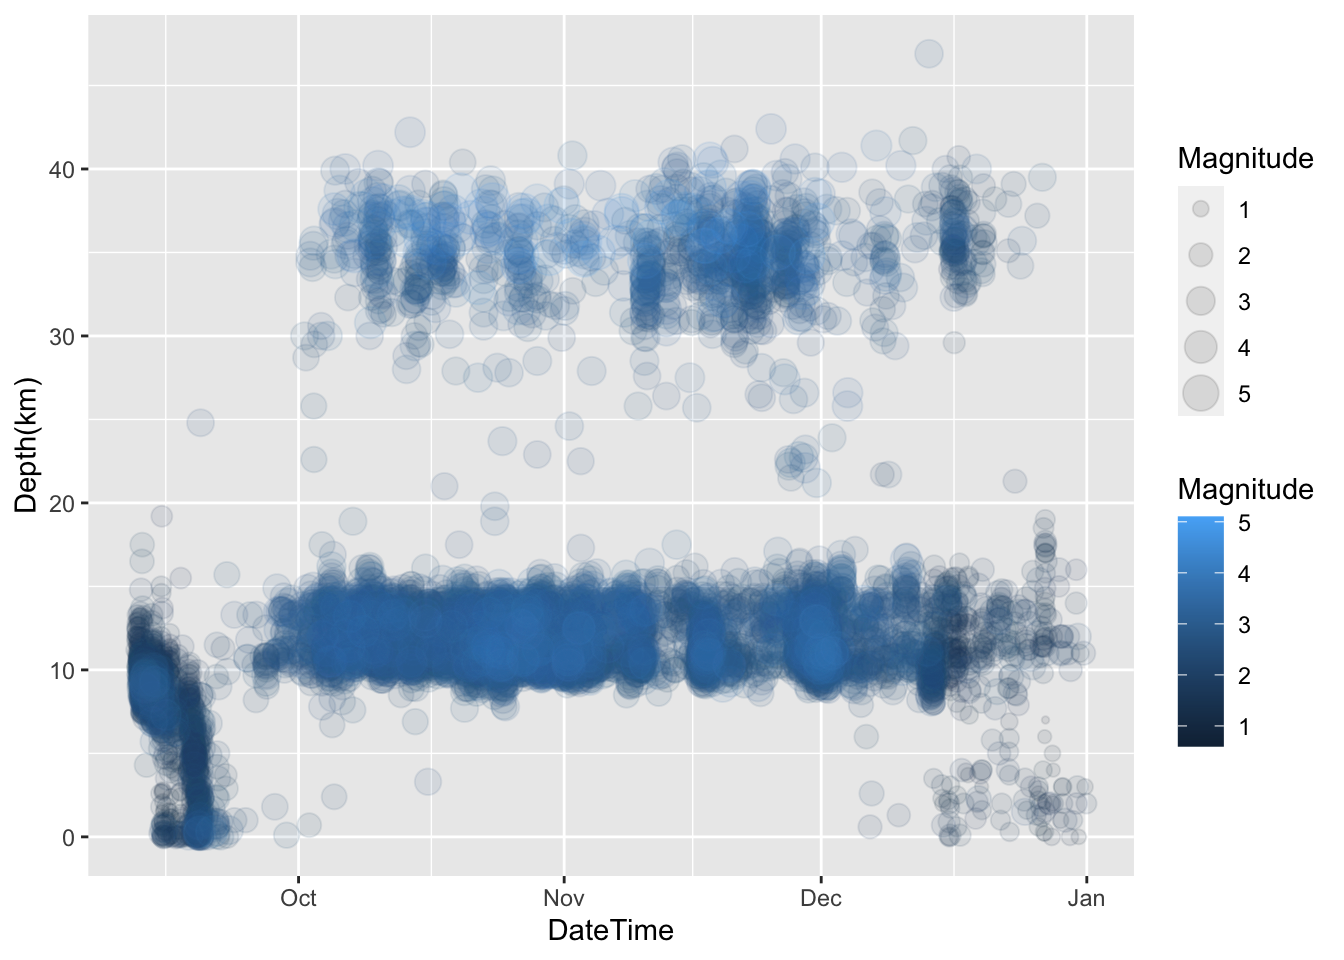

In [ ]:
df_erupt |>
  arrange(Magnitude) |> 
  ggplot(aes(DateTime, `Depth(km)`)) + 
  geom_point(aes(color = Magnitude, size = Magnitude), 
    alpha = 0.1) 

## Publication plot

In [ ]:
colors <- c("#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a",
  "#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2",
  "#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5")

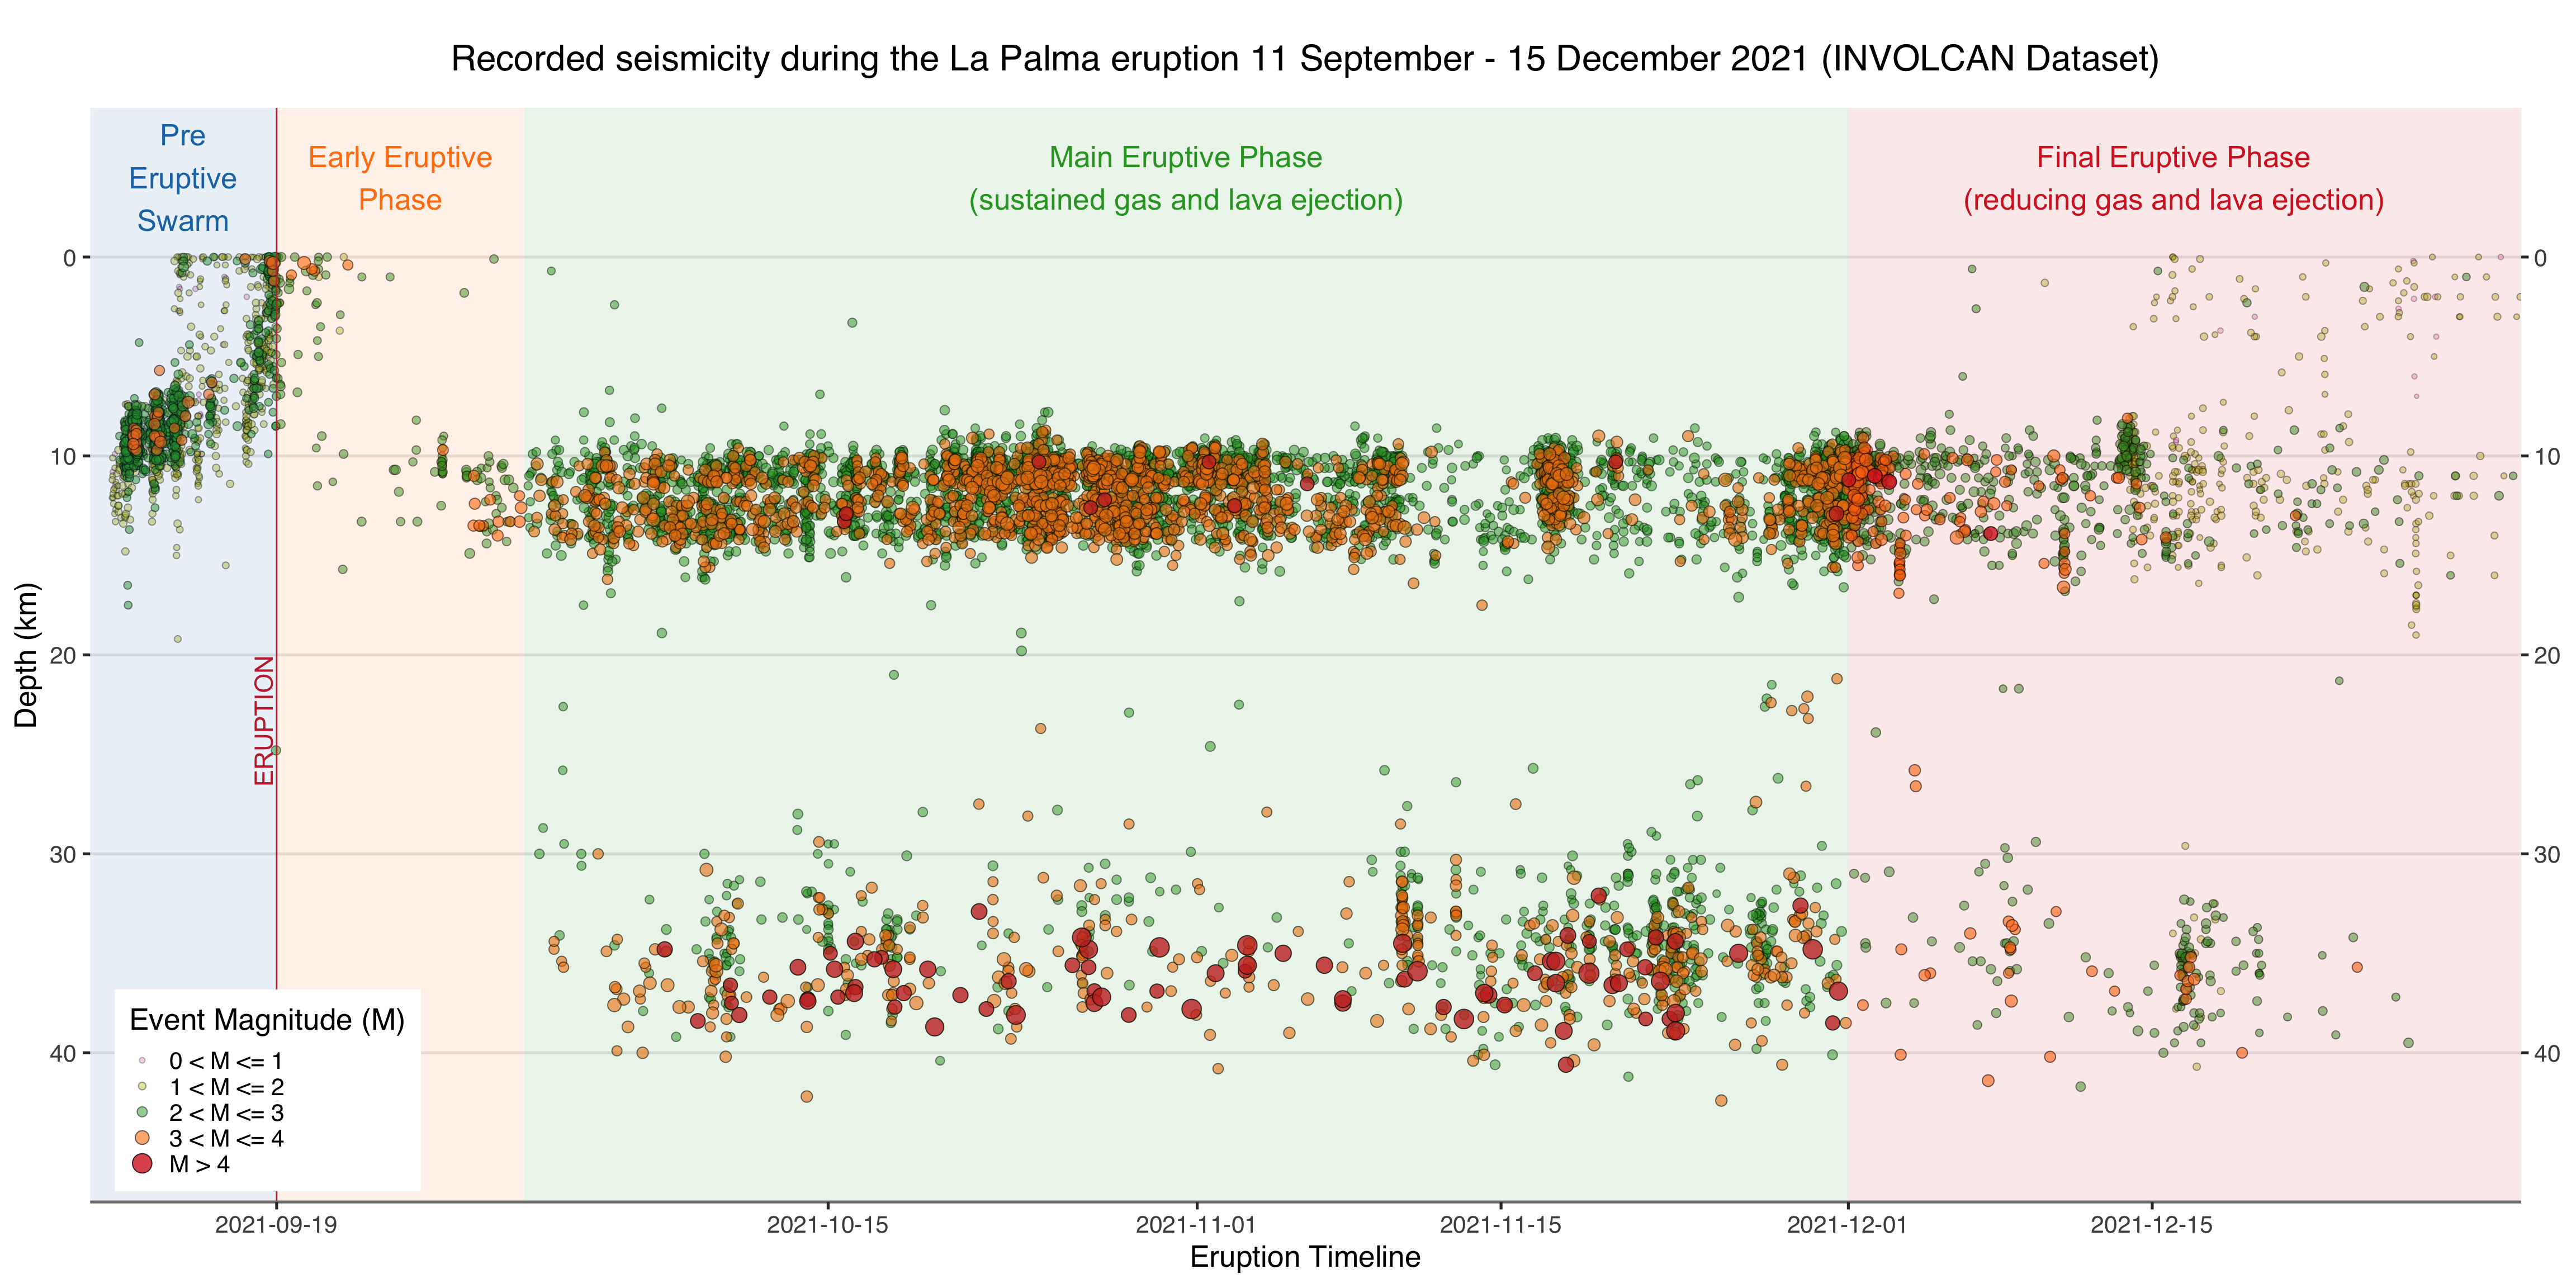

In [ ]:
eruption <- ymd_hms("2021-09-19 14:13:00")
date_axis_breaks <- as.Date("2021-10-15") + months(rep(0:2, each = 2)) - 
      days(rep(c(14, 0), times = 3))
date_axis_breaks <- c(eruption, date_axis_breaks[-1])

# Custom Magnitude Scale transform
trans_mag <- scales::trans_new(
  name = "Magnitude transformation",
  transform = \(x) 3*2^(1.3*x),
  inverse = \(x) (1/1.3) * log2(x/3)
)

  
df_erupt |>
  arrange(Magnitude) |> 
  ggplot(aes(DateTime, `Depth(km)`)) + 
  geom_point(aes(fill = Magnitude_categories, size = Magnitude,
    alpha = Magnitude_categories), shape = 21, color = "black") +
  geom_vline(xintercept = eruption, color = colors[7]) +
  annotate("text", x = eruption, y = 20, label = "ERUPTION", 
    color = colors[7], angle = 90, hjust = 1, vjust = -0.2, size = 6) +
  annotate("rect", xmin = epochs$start, xmax = epochs$end,
    ymin = -Inf, ymax = Inf, fill = colors[c(1, 3, 5, 7, 7)], alpha = 0.1) + 
  annotate("text", x =  epochs$start + 0.5*(epochs$end - epochs$start), y = -4, 
    label = epochs$text, color = colors[c(1, 3, 5, 7, NA)], size = 7) +
  scale_y_continuous("Depth (km)", trans = scales::reverse_trans(), 
    breaks = seq(0, 40, 10), limits = c( 45, -5), sec.axis = dup_axis()) +
  scale_x_datetime("Eruption Timeline", expand = c(0, 0), 
    date_labels = "%Y-%m-%d", breaks = date_axis_breaks) +
  scale_fill_manual("Event Magnitude (M)", values = colors[c(13, 17, 5, 3, 7)]) +
  scale_alpha_manual("Event Magnitude (M)", values = c(0.3, 0.4, 0.5, 0.6, 0.8)) +
  scale_size("Event Magnitude (M)", breaks = 1:5, labels = mag_labels, 
    trans = trans_mag) +
  theme_bw(base_size = 20, base_family = "Helvetica") + 
  theme(
    legend.position = c(0.01, 0.01), 
    legend.justification = c("left", "bottom"),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank(),
    panel.border = element_blank(),
    axis.line.x.bottom = element_line(color = "grey50"),
    axis.title.y.right = element_blank(),
    plot.title = element_text(hjust = 0.5, margin = margin(t = 20, b = 20))
  ) +
  labs(title = "Recorded seismicity during the La Palma eruption 11 September - 15 December 2021 (INVOLCAN Dataset)")